# Circular flow in a district heating grid

This example demonstrates how to model and analyze a simple district heating network with a circular flow using pandapipes.

The network consists of a pump that supplies hot water, which flows through consumers (heat exchangers), releases heat, and then returns to the pump. In addition to pressure and velocity distribution, the temperature profile throughout the network is also calculated. Due to losses, the temperature will fall. The heat consumer removes more heat from the network. On its way back to the pump, the temperature will fall further. 

The setup is based on a typical district heating grid topology, where the fluid returns to the pump after passing through the consumers.

*Note: The illustration may need to be updated.*

<img src="../pics/heat.png">

To set up this network, at first, the pandapipes package has to be imported. Additionally, a net container is created and, at the same time, water as a fluid is chosen.

In [49]:
import pandapipes as pp

# create empty net
net = pp.create_empty_network(fluid ="water")

Note that the flow of the example network flows in a closed loop. We will need four junctions.
The parameters `pn_bar` and `tfluid_k` that have to be set in the `create_junction`-function
are
only used as starting points for the network simulation. The fix pressure and fluid temperature is
being determined by the circular pump component which will be created afterwards.

In [50]:
j0 = pp.create_junction(net, pn_bar=4, tfluid_k=293.15, name="junction 0")
j1 = pp.create_junction(net, pn_bar=4, tfluid_k=293.15, name="junction 1")
j2 = pp.create_junction(net, pn_bar=4, tfluid_k=293.15, name="junction 2")
j3 = pp.create_junction(net, pn_bar=4, tfluid_k=293.15, name="junction 3")

Now, the pump will be created. The type of pump we choose needs a mass flow, a pressure level and a
temperature as input. Note that the circular pump is a component, which internally consists of an
external grid, connected to the junction specified via the from_junction-parameter and a sink,
connected to the junction specified via the to_junction-parameter.

However, the internal structure is not visible to the user, so that the circular pump const pressure component
supplies a fluid flow with the specified properties.

In [51]:
pp.create_circ_pump_const_pressure(net, return_junction=j0, flow_junction=j1, p_flow_bar=4, plift_bar=1.5, t_flow_k=273.15+70,
                                    type="auto", name="const_pressure_pump", index=None, in_service=True)

0

Next, the heat consumer component is created.
The most important parameter for this component is the heat flux `qext_w`. A positive value of
`qext_w` means that heat is withdrawn from the network and supplied to a consumer.
A negative value of `qext_w` corresponds to a heat source, i. e. thermal energy is being transfered
from the heat exchanger into the network.

Additionaly, controlled_mdot_kg_per_s, deltat_k or treturn_k can be added

In [52]:
pp.create_heat_consumer(net, from_junction=j2, to_junction=j3, qext_w=10000, controlled_mdot_kg_per_s=None,
                         deltat_k=None, treturn_k=50, name=None, index=None, in_service=True, type="heat_consumer")

0

The following commands defines the pipes between the components. Each pipe will consist of five
internal sections in order to improve the spatial resolution for the temperature calculation.
The parameter `text_k` specifies the ambient temperature on the outside of the pipe. It is used to
calculate energy losses.

In [53]:
pp.create_pipe(net, from_junction=j1, to_junction=j2, std_type="110/202 PLUS", length_km=1, k_mm=0.1, loss_coefficient=0,
               sections=5, text_k=283, qext_w=0., name="pipe_0_1", index=None, geodata=None, in_service=True, type="pipe")
pp.create_pipe(net, from_junction=j3, to_junction=j0, std_type="110/202 PLUS", length_km=1, k_mm=0.1, loss_coefficient=0,
               sections=5, text_k=283, qext_w=0., name="pipe_1_2", index=None, geodata=None, in_service=True, type="pipe")

1


We now run a pipe flow.


In [54]:
pp.pipeflow(net, mode='bidirectional', iter=100)

By default, only the pressure and velocity distribution is calculated by the pipeflow function. If
the `mode`-parameter is set to "all", the heat transfer calculation is started automatically
after the hydraulics computation. Computed mass flows are used as an input for the temperature
calculation. After the computation, you can check the results for junctions and pipes:

In [55]:
net.res_junction

,p_bar,t_k
0,2.500000,225.464713
1,4.000000,343.150000
2,3.999974,297.097587
3,2.500303,50.000000


Note that a constant heat flow is extracted via the heat exchanger between nodes 1 and 2. Heat
losses due to the ambient temperature level are not taken into account. These are only included in
the pipe components. This also means that - if the extracted heat flow is large enough - the
temperature level behind the heat exchanger might be lower than the ambient temperature level. A
way to avoid this behaviour would be to create a controller which defines a function for the
extracted heat in dependence of the ambient temperature.

In [56]:
net.res_pipe

,v_mean_m_per_s,p_from_bar,p_to_bar,t_from_k,t_to_k,t_outlet_k,mdot_from_kg_per_s,mdot_to_kg_per_s,vdot_m3_per_s,reynolds,lambda
0,0.001181,4.000000,3.999974,343.15,297.097587,297.097587,0.009375,-0.009375,0.000009,189.304289,0.376229
1,0.001173,2.500303,2.500000,50.00,225.464713,225.464713,0.009375,-0.009375,0.000009,16.052576,4.459393


The command above shows the results for the pipe components. The temperatures of the adjacent
junctions are displayed. Due to heat losses, the temperatures at the to-nodes is lower than the
temperatures at the from-nodes. Note also that the junctions are not equal to the internal nodes,
introduced by the pipe sections we defined. To display the temperatures at the internal nodes, we
can retrieve the internal node values with the following commands:

In [57]:
from pandapipes.component_models import Pipe
pipe_results = Pipe.get_internal_results(net, [0])

The parameters of the get_internal_results function correspond to the net and the pipes we want to
evaluate. In this case, only the results of pipe zero are retrieved. The returned value stored in
pipe_results is a dictionary, containing fields for the pressure, the velocity and the temperature.
The dictionary can either be used for own evaluations now or it can be used to plot the results over
the pipe length:


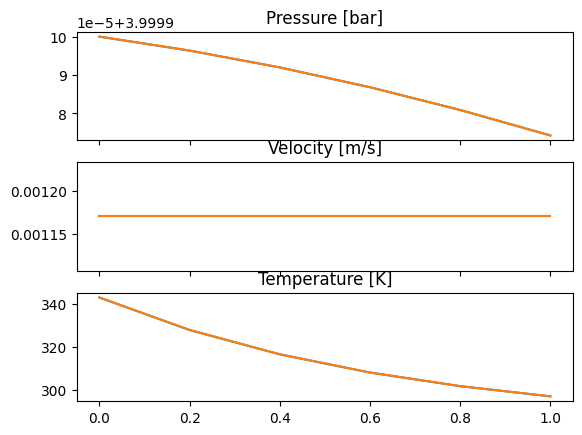

In [58]:
Pipe.plot_pipe(net, 0, pipe_results)

We can see that the pressure level falls due to friction. As the fluid is incompressible, the
velocity remains constant over the pipe length. Because the temperature level at the pipe entry is
higher than the ambient temperature, the temperature level decreases.